In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api
import matplotlib.pyplot as plt

In [2]:
# Load the data
data = pd.read_csv(r"..\cleaned_datasets\fullData.csv")

# Subset to interesting columns
keepVars = [
    'bctcb2020', 'shape_area', 'modzcta', 'boroname',
    'numGrocery', 'numRestaurant', 'numSubway',
    'numCrime', 'numViolent',
    'No Internet Access (Percentage of Households)'
]
data = data[keepVars]
data = data.rename({'No Internet Access (Percentage of Households)':'percNoInternet'}, axis='columns')

In [3]:
# Attach price per zip
priceData = pd.read_csv(r"..\cleaned_datasets\price_per_zip.csv")
data = data.merge(
    priceData,
    on='modzcta'
)

In [4]:
# Normalize count by area
data = data.assign(groc_per_area = (data['numGrocery'] / data['shape_area']))
data = data.assign(rest_per_area = (data['numRestaurant'] / data['shape_area']))
data = data.assign(subw_per_area = (data['numSubway'] / data['shape_area']))
data = data.assign(crim_per_area = (data['numCrime'] / data['shape_area']))
data = data.assign(viol_per_area = (data['numViolent'] / data['shape_area']))

In [5]:
# Final dataset
keepVars = [
    'sale_price',
    'groc_per_area', 'rest_per_area', 'subw_per_area',
    'crim_per_area', 'viol_per_area',
    'percNoInternet',
    'bctcb2020', 'boroname', 'modzcta'
]
data = data[keepVars]
data.describe()

,sale_price,groc_per_area,rest_per_area,subw_per_area,crim_per_area,viol_per_area,percNoInternet,bctcb2020,modzcta
count,3.740400e+04,37404.000000,37404.000000,37404.000000,37404.000000,37404.000000,37404.000000,3.740400e+04,37404.000000
mean,8.146743e+05,0.000091,0.002209,0.000033,0.043315,0.013960,0.166320,3.297173e+10,10931.386723
std,2.855060e+05,0.000264,0.008118,0.000130,0.135179,0.046663,0.056644,1.178984e+10,519.101920
min,3.850000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000100e+10,10001.000000
25%,6.200000e+05,0.000015,0.000254,0.000000,0.006754,0.002116,0.125200,2.046209e+10,10455.000000
50%,7.265245e+05,0.000039,0.000613,0.000009,0.015748,0.005129,0.155700,3.117800e+10,11213.000000
75%,9.500000e+05,0.000086,0.001567,0.000030,0.038943,0.012823,0.201900,4.080901e+10,11367.000000
max,2.350000e+06,0.020626,0.573098,0.015498,10.430340,4.773469,0.323600,5.032300e+10,11697.000000


In [6]:
# Check correlation between predictors
# Multicollinearity can invalidate linear model
data[['groc_per_area','rest_per_area','subw_per_area', 'crim_per_area','viol_per_area','percNoInternet']].corr()

,groc_per_area,rest_per_area,subw_per_area,crim_per_area,viol_per_area,percNoInternet
groc_per_area,1.000000,0.827008,0.733572,0.886406,0.807263,0.060827
rest_per_area,0.827008,1.000000,0.652287,0.791916,0.628170,-0.046028
subw_per_area,0.733572,0.652287,1.000000,0.778079,0.765896,0.020653
crim_per_area,0.886406,0.791916,0.778079,1.000000,0.967399,0.099278
viol_per_area,0.807263,0.628170,0.765896,0.967399,1.000000,0.139769
percNoInternet,0.060827,-0.046028,0.020653,0.099278,0.139769,1.000000


In [7]:
# Only keep subways because there is strong collinearity in grocery, restaurants, and subways
# Assumes that the grocery stores and restaurants are located with respect to subways

# Create a multilevel model to predict price per square foot
# Since housing prices are often log-normal, do a log transform on y
# Add a random intercept for the borough that each block is in
model = smf.mixedlm(
    "np.log(sale_price) ~ subw_per_area + viol_per_area + percNoInternet", 
    data, 
    groups=data['boroname']
)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:            MixedLM Dependent Variable: np.log(sale_price)
No. Observations: 37404   Method:             REML              
No. Groups:       5       Scale:              0.0393            
Min. group size:  3995    Log-Likelihood:     7448.6106         
Max. group size:  13759   Converged:          Yes               
Mean group size:  7480.8                                        
-----------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|  [0.025   0.975]
-----------------------------------------------------------------
Intercept        13.566     0.141  96.271  0.000  13.290   13.842
subw_per_area    78.985    12.445   6.347  0.000  54.593  103.377
viol_per_area    -0.194     0.035  -5.543  0.000  -0.263   -0.126
percNoInternet    0.126     0.021   5.997  0.000   0.085    0.168
Group Var         0.099     0.335                                
================================================================

"""

In [8]:
# From the model summary:
# There are differences between boroughs, but not enough to matter (Std.Err.)
# Increasing subway access decreases price on average
# Increasing violent crime prevalence increases price on average
# Increasing percent of households without internet increases price on average
#
# My suspicion is that this comes down to exclusivity: More subway access means
# that you are in a more central area, which is less exclusive, which is less desirable.
# Additionally, if you can afford to be away from a subway, you probably get around the city
# using other kinds of transportation. I think this is also why as fewer households have internet
# the price also increases. Infrastructure is centralized. Violent crime is really interesting. Could be that 
# people do more violent crime in more affluent areas, and not in the areas they live in.

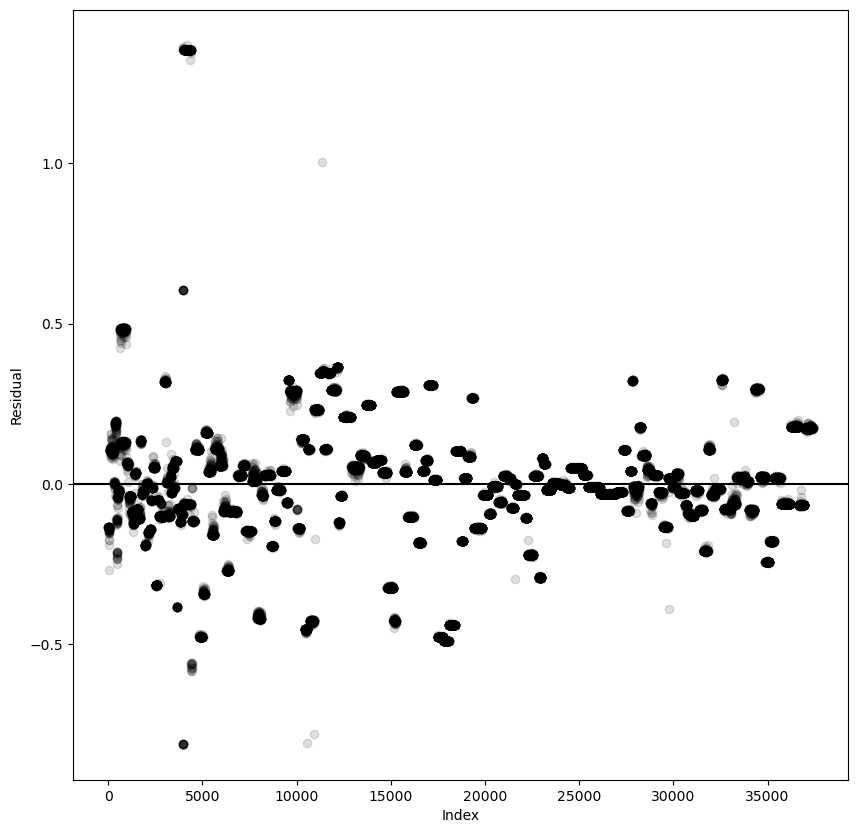

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(
    x=range(0, data.shape[0]),
    y=model.resid,
    c="#00000020"
)
ax.axline((0, 0), slope=0, color='#000000')
ax.set(xlabel = 'Index', ylabel='Residual')
plt.show()

In [10]:
# Residual plot is used to check for violations in the error assumptions for regression.
# What I notice mostly is that lots of the points are centered together. This is probably
# because the price per square foot is calculated at the zip code level, but the observations
# are at the block level. Just a limitation.
#
# Violation-wise, it looks mostly okay. I'm not seeing anything that looks like the residuals
# are abnormal.

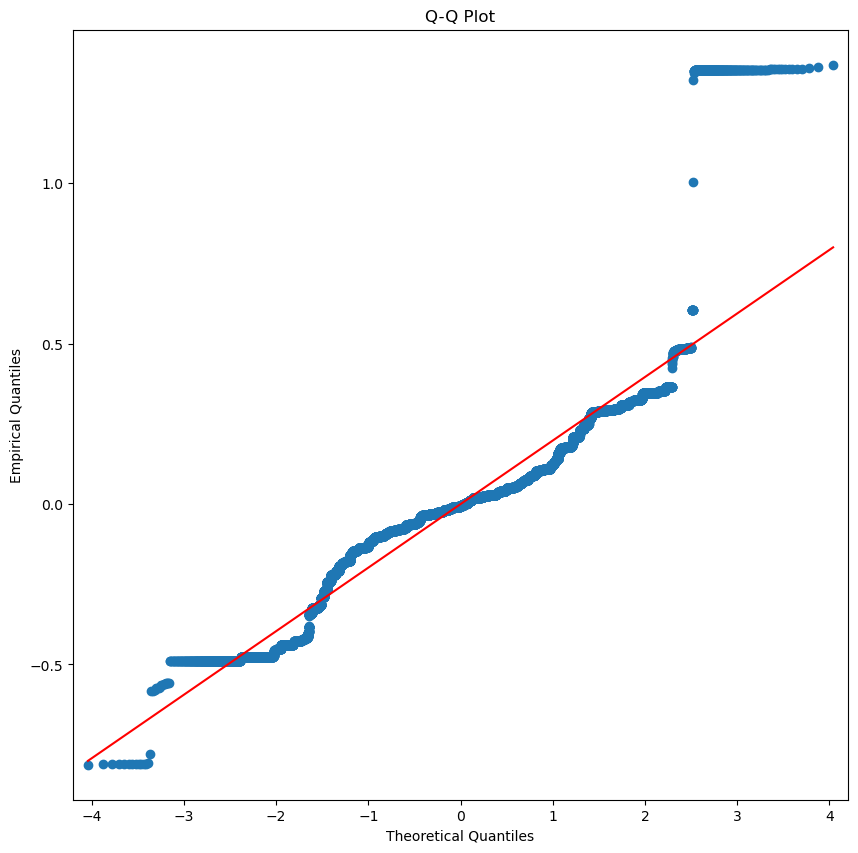

In [11]:
# Q-Q plot
fig, ax = plt.subplots(figsize=(10,10))
statsmodels.api.qqplot(model.resid, line='s', ax=ax)
ax.set(xlabel = 'Theoretical Quantiles', ylabel='Empirical Quantiles')
ax.set_title("Q-Q Plot")
plt.show()

In [12]:
# The Q-Q plot is for checking if the residuals are normally distributed.
# If they are, they would all fall on the red line, which is not happening here.
# This implies that the model is not capturing the true price per square foot of
# blocks that are at the far edges (low and high prices), but does okay in the middle.
# We might interpret this like as saying that exclusivity makes more sense for medium desirable areas,
# but that the most expensive and most cheap are drived by other (maybe social) factors that aren't
# in this model.

In [13]:
# Calculate the predicted change in price per square foot assuming you go from
# the least amount to the most amount (as found in our data).
#
# Interpret like this:
# "Assuming all else equal, the block with the most subway access per area 
# is associated with a 68.6% decrease in price on average compared to the 
# block with the lease subway access."
#
# Note: The percent interpretation only happens because the model predicts the 
# price per square foot on the log scale.

# Subway
# Decrease by 240%
print(100 * (np.exp(78.985 * (0.015498 - 0.000000)) - 1))

# Violence
# Decrease by 60%
print(100 * (np.exp(-0.194 * (4.773469 - 0.000000)) - 1))

# Percent No Internet
# Increase by 3%
print(100 * (np.exp(0.126 * (0.323600 - 0.058300)) - 1))

240.11361242628752
-60.38859032020358
3.399278675199069
